### npy load

In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2024-01-21 06:27:38.468387: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 06:27:38.565588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 06:27:40.620656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-21 06:27:44.641628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capabi

In [2]:
import matplotlib.pyplot as plt
import cv2, os, glob
import numpy as np
from PIL import Image

In [3]:
train_images =  np.load('/home/nas/data/eunju/Industrial/leather/train_images.npy')
train_labels =  np.load('/home/nas/data/eunju/Industrial/leather/train_labels.npy')

val_images =  np.load('/home/nas/data/eunju/Industrial/leather/val_images.npy')
val_labels =  np.load('/home/nas/data/eunju/Industrial/leather/val_labels.npy')

test_images =  np.load('/home/nas/data/eunju/Industrial/leather/test_images.npy')
test_labels =  np.load('/home/nas/data/eunju/Industrial/leather/test_labels.npy')

### 6:2:2 비율
- 총 92개

In [4]:
print("train_images:", train_images.shape)
print("train_labels:", train_labels.shape)
print("test_images: ", test_images.shape)
print("test_labels: ", test_labels.shape)
print("val_images:  ", val_images.shape)
print("val_labels:  ", val_labels.shape)

train_images: (55, 256, 256, 3)
train_labels: (55, 256, 256)
test_images:  (19, 256, 256, 3)
test_labels:  (19, 256, 256)
val_images:   (18, 256, 256, 3)
val_labels:   (18, 256, 256)


### 데이터 회전 추가

In [7]:
import numpy as np

# 회전 함수
def rotate_images_labels(images, labels, rotation_angle):
    rotated_images = [np.rot90(img, k=rotation_angle // 90) for img in images]
    rotated_labels = [np.rot90(lbl, k=rotation_angle // 90) for lbl in labels]

    return rotated_images, rotated_labels

# 회전할 각도 리스트
rotation_angles = [90, 180, 270]

# 데이터 회전
for angle in rotation_angles:
    rotated_train_images, rotated_train_labels = rotate_images_labels(train_images, train_labels, rotation_angle=angle)
    rotated_val_images, rotated_val_labels = rotate_images_labels(val_images, val_labels, rotation_angle=angle)
    rotated_test_images, rotated_test_labels = rotate_images_labels(test_images, test_labels, rotation_angle=angle)

    # 데이터 추가하기
    train_images = np.concatenate([train_images, rotated_train_images], axis=0)
    train_labels = np.concatenate([train_labels, rotated_train_labels], axis=0)

    val_images = np.concatenate([val_images, rotated_val_images], axis=0)
    val_labels = np.concatenate([val_labels, rotated_val_labels], axis=0)

# 데이터 차원 확인
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)

print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (440, 256, 256, 3)
Train Labels Shape: (440, 256, 256)
Validation Images Shape: (144, 256, 256, 3)
Validation Labels Shape: (144, 256, 256)


### image 확인

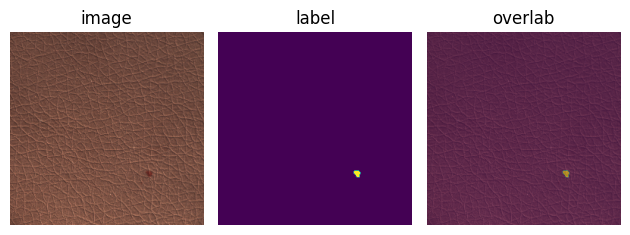

In [8]:
plt.subplot(131); plt.imshow(train_images[400]); plt.title("image") ; plt.axis(False)
plt.subplot(132); plt.imshow(train_labels[400]); plt.title("label") ; plt.axis(False)
plt.subplot(133); plt.imshow(train_images[400]); plt.axis(False)
plt.subplot(133); plt.imshow(train_labels[400], alpha=0.5) ;plt.title('overlab') ; plt.axis(False)
plt.tight_layout() ; plt.show()

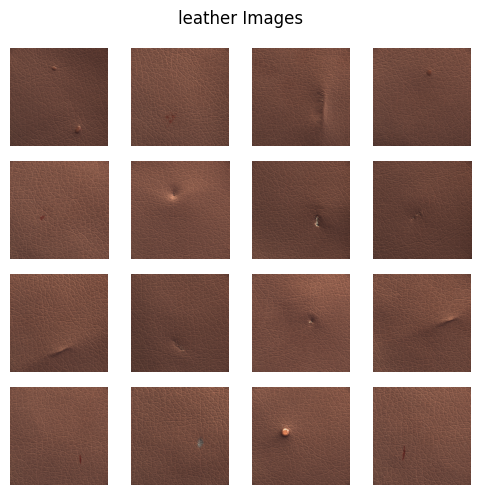

In [9]:
import random

# 랜덤 16개 선택
random_indices = random.sample(range(test_images.shape[0]), 16)
fig, axs = plt.subplots(4, 4, figsize=(5, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(test_images[random_indices[i]])
    ax.axis('off')
    
plt.suptitle("leather Images")
plt.tight_layout()
plt.show()

### 네트워크

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Middle
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)

# Decoder
up8 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv1], axis=-1)
conv8 = Conv2D(8, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv8)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

2024-01-21 06:28:33.649613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=300, batch_size=32)

Epoch 1/300


2024-01-21 06:28:46.562686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-21 06:28:47.927962: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 06:28:48.378975: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-21 06:28:48.449886: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-21 06:28:48.902615: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate

14/14 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.9918

2024-01-21 06:28:55.685035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 15s 230ms/step - loss: 0.4230 - accuracy: 0.9918 - val_loss: 0.1137 - val_accuracy: 0.9849
Epoch 2/300
14/14 [==============================] - 1s 45ms/step - loss: 0.0677 - accuracy: 0.9918 - val_loss: 0.1508 - val_accuracy: 0.9849
Epoch 3/300
14/14 [==============================] - 1s 45ms/step - loss: 0.0688 - accuracy: 0.9918 - val_loss: 0.0987 - val_accuracy: 0.9849
Epoch 4/300
14/14 [==============================] - 1s 44ms/step - loss: 0.0534 - accuracy: 0.9918 - val_loss: 0.0872 - val_accuracy: 0.9849
Epoch 5/300
14/14 [==============================] - 1s 45ms/step - loss: 0.0518 - accuracy: 0.9918 - val_loss: 0.0922 - val_accuracy: 0.9849
Epoch 6/300
14/14 [==============================] - 1s 45ms/step - loss: 0.0514 - accuracy: 0.9918 - val_loss: 0.0883 - val_accuracy: 0.9849
Epoch 7/300
14/14 [==============================] - 1s 45ms/step - loss: 0.0509 - accuracy: 0.9918 - val_loss: 0.0892 - val_accuracy: 0.9849
Epoch 8/300
14/1

14/14 [==============================] - 1s 66ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0347 - val_accuracy: 0.9903
Epoch 116/300
14/14 [==============================] - 1s 55ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 0.0406 - val_accuracy: 0.9900
Epoch 117/300
14/14 [==============================] - 1s 56ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 0.0372 - val_accuracy: 0.9903
Epoch 118/300
14/14 [==============================] - 1s 58ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0362 - val_accuracy: 0.9904
Epoch 119/300
14/14 [==============================] - 1s 56ms/step - loss: 0.0173 - accuracy: 0.9948 - val_loss: 0.0367 - val_accuracy: 0.9903
Epoch 120/300
14/14 [==============================] - 1s 62ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 0.0356 - val_accuracy: 0.9904
Epoch 121/300
14/14 [==============================] - 1s 61ms/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.0384 - val_accuracy: 0.9903
Epoch 

Epoch 172/300
14/14 [==============================] - 1s 70ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0343 - val_accuracy: 0.9909
Epoch 173/300
14/14 [==============================] - 1s 71ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0338 - val_accuracy: 0.9910
Epoch 174/300
14/14 [==============================] - 1s 64ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0330 - val_accuracy: 0.9910
Epoch 175/300
14/14 [==============================] - 1s 62ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0353 - val_accuracy: 0.9908
Epoch 176/300
14/14 [==============================] - 1s 59ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0338 - val_accuracy: 0.9908
Epoch 177/300
14/14 [==============================] - 1s 57ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0375 - val_accuracy: 0.9906
Epoch 178/300
14/14 [==============================] - 1s 62ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0337 - val_accuracy:

Epoch 229/300
14/14 [==============================] - 1s 71ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0354 - val_accuracy: 0.9913
Epoch 230/300
14/14 [==============================] - 1s 70ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.0334 - val_accuracy: 0.9914
Epoch 231/300
14/14 [==============================] - 1s 68ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0332 - val_accuracy: 0.9914
Epoch 232/300
14/14 [==============================] - 1s 63ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0359 - val_accuracy: 0.9913
Epoch 233/300
14/14 [==============================] - 1s 61ms/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0322 - val_accuracy: 0.9914
Epoch 234/300
14/14 [==============================] - 1s 65ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0360 - val_accuracy: 0.9911
Epoch 235/300
14/14 [==============================] - 1s 58ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.0434 - val_accuracy:

Epoch 286/300
14/14 [==============================] - 1s 44ms/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 0.0352 - val_accuracy: 0.9913
Epoch 287/300
14/14 [==============================] - 1s 46ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0343 - val_accuracy: 0.9912
Epoch 288/300
14/14 [==============================] - 1s 45ms/step - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.0305 - val_accuracy: 0.9915
Epoch 289/300
14/14 [==============================] - 1s 46ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.0356 - val_accuracy: 0.9913
Epoch 290/300
14/14 [==============================] - 1s 47ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.0332 - val_accuracy: 0.9914
Epoch 291/300
14/14 [==============================] - 1s 51ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0351 - val_accuracy: 0.9914
Epoch 292/300
14/14 [==============================] - 1s 53ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.0322 - val_accuracy:

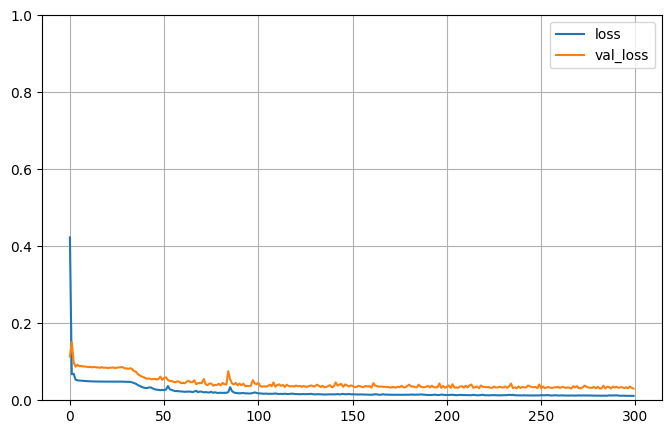

(<matplotlib.legend.Legend at 0x7fbb6c7b4c70>, None, None)

In [12]:
plot_target = ['loss', 'val_loss']

plt.figure(figsize=(8,5))

for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.ylim(0,1)
plt.legend(), plt.grid(), plt.show()

<br>

### evaluate

In [13]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

1/1 - 0s - loss: 0.0078 - accuracy: 0.9974 - 410ms/epoch - 410ms/step


In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

pred = model.predict(val_images)
pred = (pred > 0.5).astype(int)  # 임계값 설정

# 실제 라벨과 예측 라벨을 1차원 배열로 변환
true_labels = val_labels.flatten()
pred_labels = pred.flatten()

precision = precision_score(true_labels, pred_labels)
print("정밀도:", round(precision,3))

recall = recall_score(true_labels, pred_labels);
print("재현율:", round(recall,3))

f1 = f1_score(true_labels, pred_labels)
print("F1점수:", round(f1,3))

5/5 [==============================] - 0s 18ms/step
정밀도: 0.804
재현율: 0.593
F1점수: 0.682


1/1 [==============================] - 0s 319ms/step
diff:  109


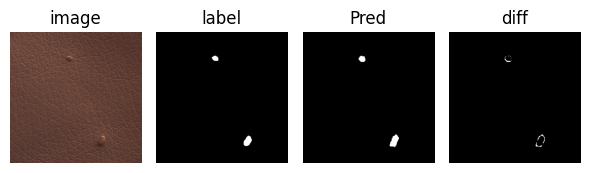

In [15]:
num = 1

test_image = test_images[num]
test_label = test_labels[num]
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
prediction = np.where(prediction > 0.5, 1, 0)
diff= abs(test_label-prediction[:,:,0])
count = np.count_nonzero(diff==1)
print("diff: ",count)

plt.figure(figsize=(6,4))
plt.subplot(141) ;  plt.imshow(test_image, cmap='gray') ; plt.title('image');plt.axis('off')
plt.subplot(142) ;  plt.imshow(test_label, cmap='gray') ; plt.title('label'); plt.axis('off')
plt.subplot(143) ;  plt.imshow(prediction, cmap='gray') ; plt.title('Pred'); plt.axis('off')
plt.subplot(144) ; plt.imshow(diff, cmap='gray'); plt.title('diff') ; plt.axis('off')
plt.tight_layout();plt.show()

### test dataset에서 틀린 픽셀 수

In [16]:
test_images.shape

(19, 256, 256, 3)

In [17]:
diff_counts = []

for i in range(len(test_images)):
    test_image = test_images[i]
    test_label = test_labels[i]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.where(prediction > 0.5, 1, 0)
    diff = abs(test_label-prediction[:,:,0])
    count = np.count_nonzero(diff==1)
    diff_counts.append(count)

total = sum(diff_counts)
print("total diff: ", total)

1/1 [==============================] - 0s 46ms/step
total diff:  3227


<br>

### 모델 저장

In [26]:
#model.save('.../seg.h5')